In [1]:
import pandas as pd
import torch.nn.functional as F
from scheduler import instantiate_scheduler

In [2]:
metadata = pd.read_excel('dataset/metadata.xlsx')
metadata['File Location'] = [path.replace(".\\HNSCC", "./dataset/HNSCC").replace("\\", "/")
                             for path in metadata['File Location']]
infodata = pd.read_excel('dataset/HNSCC-MDA-Data_update_20240514.xlsx')
metadata = pd.merge(metadata, infodata, left_on = 'Subject ID', right_on = 'TCIA PatientID', how = 'left')
metadata.iloc[:62,:]

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/metadata.xlsx'

In [14]:
columns_to_onehot = ['Sex', 'Diag', 'Site', 'Platinum-based chemotherapy', 'Received Concurrent Chemoradiotherapy', 'CCRT Chemotherapy Regimen', 
                    'Unplanned Additional Oncologic Treatment', 'PreRT Skeletal Muscle status', 'PostRT Skeletal Muscle status']
metadata = pd.get_dummies(metadata, columns=columns_to_onehot, prefix=columns_to_onehot)

In [15]:
cause_of_death_mapping = {
    'Alive': 0,
    'HN Cancer': 1,
    'Non cancer related': 2,
    'Other Cancer': 2,
    'Other cancer': 2,
    'Unknown': 2,
}
grade_mapping = {
    'undiff.': 0,
    'poorly diff.': 1,
    'moderately to poorly diff.': 2,
    'moderately diff.': 3,
    'well to moderately diff.': 4,
    'Well to moderately diff.': 4,
    'well diff.': 5
}
stage_mapping = {
    'I': 1,
    "II": 2,
    "III": 3,
    'IVA': 4,
    'IVB': 4
}
metadata['Cause of Death'] = metadata['Cause of Death'].map(cause_of_death_mapping)
metadata['Grade'] = metadata['Grade'].map(grade_mapping)
metadata['Stage'] = metadata['Stage'].map(stage_mapping)

In [19]:
df = metadata.iloc[:, list(range(4, 9)) + list(range(12, metadata.shape[1]))]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 83 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Age                                                                                160 non-null    int64  
 1   Grade                                                                              160 non-null    int64  
 2   T                                                                                  160 non-null    int64  
 3   N                                                                                  160 non-null    int64  
 4   Stage                                                                              160 non-null    int64  
 5   RT Total Dose (Gy)                                                                 160 non-null    float64

Matplotlib created a temporary cache directory at /tmp/matplotlib-u6qh1io7 because the default path (/home/users/s1155198347/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


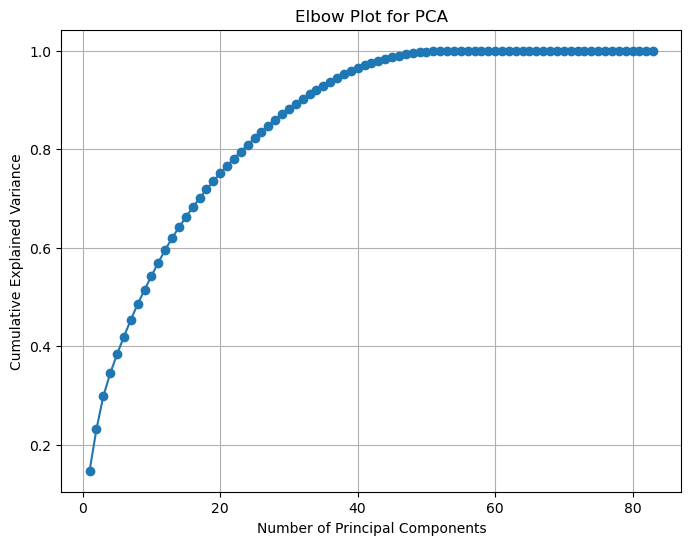

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

scaler = StandardScaler()
df_standardized = scaler.fit_transform(df)

explained_variances = []

# 尝试不同数量的主成分，从1到数据的最大特征数
for n in range(1, df_standardized.shape[1] + 1):
    pca = PCA(n_components=n)
    pca.fit(df_standardized)
    explained_variances.append(sum(pca.explained_variance_ratio_))

# 生成肘部图
plt.figure(figsize=(8, 6))
plt.plot(range(1, df_standardized.shape[1] + 1), explained_variances, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()

In [42]:
import os
import pydicom
import numpy as np
folder_path = "./dataset/HNSCC/HNSCC-01-0001/03-27-1999-NA-PETCT HEAD  NECK CA-29348/2.000000-CT Atten Cor Head IN-91259"
dicom_files = [os.path.join(folder_path, f) for f in sorted(os.listdir(folder_path)) if f.endswith('.dcm')]
slices = []
for dicom_file in dicom_files:
    ds = pydicom.dcmread(dicom_file)
    slices.append(ds.pixel_array.astype(np.float32))
    spacing = list(map(float, ds.PixelSpacing)) + [float(ds.SliceThickness)]
    orientation = ds.ImageOrientationPatient
image = np.stack(slices, axis=0)
print(image.shape)

(223, 512, 512)


In [44]:
image = np.clip(image, 300, 1024)
print(image.shape)

(223, 512, 512)


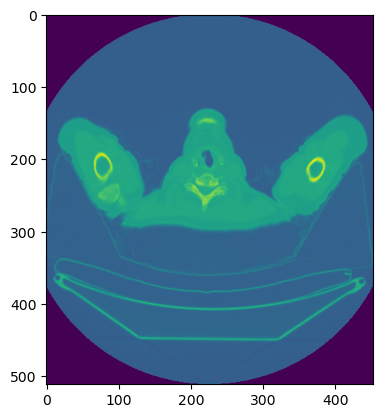

In [10]:
import matplotlib.pyplot as plt
plt.imshow(cropped_image)

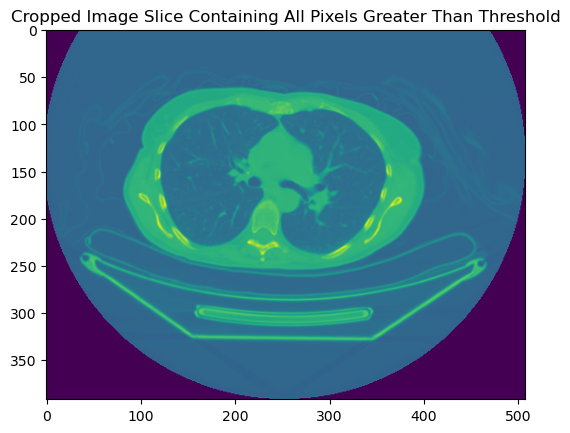

In [41]:
threshold = 300
non_zero_coords = np.argwhere(image > threshold)
min_z, min_x, min_y = np.min(non_zero_coords, axis=0)
max_z, max_x, max_y = np.max(non_zero_coords, axis=0)
cropped_image = image[min_z:max_z+1, 120:max_x+1, min_y:max_y+1]
slice_to_show = cropped_image[50, :, :]

# 显示裁剪后的图像切片
plt.imshow(slice_to_show, cmap='gray')
plt.title("Cropped Image Slice Containing All Pixels Greater Than Threshold")
plt.show()

In [20]:
print(cropped_image.shape)

(223, 512, 508)


In [39]:
np.where(image[:, 0:100, :] > 300)

(array([  0,   0,   0, ..., 220, 220, 220]),
 array([ 0,  0,  0, ..., 86, 93, 98]),
 array([243, 244, 245, ..., 447, 453, 457]))

torch.Size([360, 512, 512])


TypeError: Invalid shape (360, 512, 512) for image data

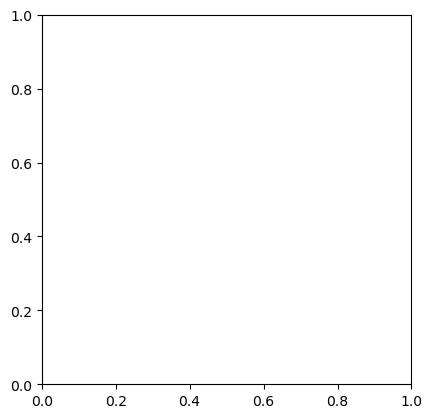

In [70]:
from monai.transforms import Resize
resize_transform = Resize(spatial_size=(512,512), mode='bilinear')
cropped_image.unsqueeze(0)
print(cropped_image.shape)
resize_image = resize_transform(cropped_image)
plt.imshow(resize_image, cmap='gray')

In [61]:
cropped_image.shape

torch.Size([360, 512, 512])

In [37]:
from monai.transforms import CropForegroundd
class Preprocessor:
    def __init__(self):
        self.crop_foreg = CropForegroundd(keys=["image"], source_key="image", threshold=1000)
    def process(self, data):
        return self.crop_foreg(data)

preprocessor = Preprocessor()
data = {"image": foreground_image}
processed_data = preprocessor.process(data)
cropped_image = processed_data["image"]

print(cropped_image.shape)

torch.Size([223, 512, 510])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

image = torch.randn(32, 1, 16, 16, 16)
table = torch.randn(32, 10)
time = torch.randint(1, 1001, (32,)).float()
label = torch.randint(0, 3, (32,))

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc = nn.Linear(4107, 2)

    def forward(self, image, table, time):
        batch = table.shape[0]
        image = image.view(batch, -1)
        time = time.unsqueeze(1)
        feature = torch.cat([image, table, time], dim = 1)
        output = self.fc(feature)

        return output

model = SimpleMLP()

In [23]:
def loss_fn(model, image, table, time, label, eps=1e-8):
    batch_size = image.size(0)
    
    # 将时间和标签按时间排序
    time, indices = torch.sort(time)
    image = image[indices]
    table = table[indices]
    label = label[indices]
    
    # 用于计算 log partial likelihood 的变量
    pll = torch.zeros(batch_size, device=image.device)
    expg_sum_list = torch.zeros(batch_size, device=image.device)

    for i in range(batch_size):
        if label[i] == 1:  # 只考虑发生了事件的情况
            sub_image = image[i:]
            sub_table = table[i:]
            t = time[i]
            n = sub_table.size(0)
            t_repeated = t.repeat(n)
            
            expg_sum = torch.sum(torch.exp(model(sub_image, sub_table, t_repeated)[:, 0]).flatten())
            expg_sum_list[i] = expg_sum

            g_pred = model(image[i:i+1], table[i:i+1], time[i:i+1])[:, 0].flatten()

            pll[i] = g_pred - torch.log(expg_sum)
    
    # 只返回发生事件的条目的损失
    pll = pll[label == 1]

    return -torch.mean(pll)

In [7]:
import pydicom
import os
import numpy as np
slices = []
for file_path in metadata["File Location"]:
    dicom_files = [os.path.join(file_path, f) for f in sorted(os.listdir(file_path)) if f.endswith('.dcm')]
    for dicom_file in dicom_files:
        ds = pydicom.dcmread(dicom_file)
        slices.append(ds.pixel_array.astype(np.float32))

In [13]:
data = np.stack(slices)
data.shape
mean_intensity = np.mean(data)
std_intensity = np.std(data)
lower_bound = np.percentile(data, 0.5)
upper_bound = np.percentile(data, 99.5)
intensityproperties = {
    'mean': mean_intensity,
    'std': std_intensity,
    'percentile_00_5': lower_bound,
    'percentile_99_5': upper_bound
}
print(intensityproperties)

{'mean': 85.75993, 'std': 712.06006, 'percentile_00_5': -1024.0, 'percentile_99_5': 1480.0}


In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dataloader.dataset import load_dataset
df = load_dataset(dataset='METABRIC', path='./', normalize=True)
df1 = pd.DataFrame(df[0])
df1.columns = df[3]
df1['Follow up duration'] = df[1]
df1['Cause of Death'] = df[2]
df[3]

Index(['MKI67', 'EGFR', 'PGR', 'ERBB2', 'Hormone', 'Radiotherapy',
       'Chemotherapy', 'ER-positive', 'Age at diagnosis'],
      dtype='object')

In [4]:
np.unique(df[1])

array([9.99999994e-09, 1.00000009e-01, 7.66666651e-01, ...,
       3.37033325e+02, 3.51000000e+02, 3.55200012e+02])

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [7]:
np.random.seed(1234)
_ = torch.manual_seed(123)
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [8]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [16]:
durations_test

array([ 69.1      ,  35.633335 , 252.96666  , 222.2      , 107.76667  ,
       131.06667  , 263.03333  ,  86.9      , 151.16667  , 194.1      ,
        21.166666 , 166.66667  ,  22.466667 , 157.53334  , 195.8      ,
       267.4      , 146.9      ,  19.1      , 194.3      ,   0.       ,
        91.23333  ,  46.533333 ,  91.26667  ,  15.3      ,  47.433334 ,
        31.466667 , 202.1      , 176.26666  , 205.8      ,  58.633335 ,
        63.033333 , 197.43333  ,  18.233334 ,  84.2      ,  87.1      ,
        95.86667  , 114.76667  ,  48.433334 ,  80.73333  , 114.333336 ,
       164.33333  , 213.       ,  84.63333  ,  13.4      , 228.9      ,
       250.66667  , 102.066666 ,  97.433334 , 199.53334  , 109.2      ,
       134.46666  ,  64.933334 , 257.56668  , 124.26667  , 252.26666  ,
       251.2      ,  34.7      , 206.13333  , 153.56667  ,  49.766666 ,
       228.76666  ,  57.4      ,  16.6      , 134.36667  , 197.66667  ,
       184.33333  , 176.5      ,  45.333332 ,   3.5      ,  12.9

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv
np.random.seed(1234)
_ = torch.manual_seed(123)
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
model.optimizer.set_lr(0.01)

E:\anaconda\envs\pytorch\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model.fit(x_train, y_train, 256, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

ValueError: cannot convert float NaN to integer

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

metadata_path =  '/home/users/s1155198347/large-data/dataset/dataset/metadata.xlsx'
infodata_path =  '/home/users/s1155198347/large-data/dataset/dataset/HNSCC-MDA-Data_update_20240514.xlsx'

metadata = pd.read_excel(metadata_path)
metadata['File Location'] = [path.replace(".\\HNSCC", "/home/users/s1155198347/large-data/dataset/dataset/HNSCC").replace("\\", "/")
                             for path in metadata['File Location']]
infodata = pd.read_excel(infodata_path)
metadata = pd.merge(metadata, infodata, left_on='Subject ID', right_on='TCIA PatientID', how='left')


columns_to_onehot = ['Sex', 'Diag', 'Site', 'Platinum-based chemotherapy', 'Received Concurrent Chemoradiotherapy', 'CCRT Chemotherapy Regimen', 
                'Unplanned Additional Oncologic Treatment', 'PreRT Skeletal Muscle status', 'PostRT Skeletal Muscle status']
metadata = pd.get_dummies(metadata, columns=columns_to_onehot, prefix=columns_to_onehot)

cause_of_death_mapping = {
'Alive': 0,
'HN Cancer': 1,
'Non cancer related': 2,
'Other Cancer': 2,
'Other cancer': 2,
'Unknown': 2,
}
grade_mapping = {
    'undiff.': 0,
    'poorly diff.': 1,
    'moderately to poorly diff.': 2,
    'moderately diff.': 3,
    'well to moderately diff.': 4,
    'Well to moderately diff.': 4,
    'well diff.': 5
}
stage_mapping = {
    'I': 1,
    "II": 2,
    "III": 3,
    'IVA': 4,
    'IVB': 4
}
metadata['Cause of Death'] = metadata['Cause of Death'].map(cause_of_death_mapping)
metadata['Grade'] = metadata['Grade'].map(grade_mapping)
metadata['Stage'] = metadata['Stage'].map(stage_mapping)


# Extract the columns for PCA
df_pca_input = metadata.iloc[:, list(range(4, 9)) + list(range(12, metadata.shape[1]))]

# Standardize the data before applying PCA
scaler = StandardScaler()
df_pca_standardized = scaler.fit_transform(df_pca_input)

# Apply PCA to reduce to 40 dimensions
pca = PCA(n_components=40)
df_pca_result = pca.fit_transform(df_pca_standardized)

# Convert the PCA result to a DataFrame
df_pca_result = pd.DataFrame(df_pca_result, columns=[f'PC{i+1}' for i in range(40)])

# Extract the columns not used in PCA (including columns 9 to 11)
df_remaining = pd.concat([metadata.iloc[:, :4], metadata.iloc[:, 9:12]], axis=1)
# Combine the PCA results with the remaining columns
df_final = pd.concat([df_remaining, df_pca_result], axis=1)
df_final.drop(["TCIA PatientID", "Alive or Dead", "Subject ID", "Study Date"], axis = 1, inplace = True)
df_final.to_csv("/home/users/s1155198347/large-data/dataset/HNSCC_metadata.xlsx", index=False)

In [11]:
df_final[df_final["Cause of Death"] == 2]["Follow up duration"].mean()
#df_final[df_final["Cause of Death"] == 2]["Follow up duration"].max()

1752.5

In [1]:
import torch
table_data = torch.rand(2, 2, 9)
print(table_data)

# 将前两个维度合并成一个维度
flattened_table = torch.flatten(table_data, start_dim=0, end_dim=1)

# 输出新的形状
print(flattened_table)  # 输出: torch.Size([4, 9])

tensor([[[0.2881, 0.4035, 0.2300, 0.3484, 0.9025, 0.9433, 0.0995, 0.9162,
          0.8842],
         [0.3871, 0.5094, 0.1134, 0.4793, 0.7891, 0.9516, 0.5611, 0.7328,
          0.7170]],

        [[0.5181, 0.8173, 0.2741, 0.8494, 0.6460, 0.3201, 0.7824, 0.8324,
          0.8240],
         [0.3181, 0.9167, 0.1920, 0.4634, 0.8744, 0.5981, 0.1695, 0.2395,
          0.5537]]])
tensor([[0.2881, 0.4035, 0.2300, 0.3484, 0.9025, 0.9433, 0.0995, 0.9162, 0.8842],
        [0.3871, 0.5094, 0.1134, 0.4793, 0.7891, 0.9516, 0.5611, 0.7328, 0.7170],
        [0.5181, 0.8173, 0.2741, 0.8494, 0.6460, 0.3201, 0.7824, 0.8324, 0.8240],
        [0.3181, 0.9167, 0.1920, 0.4634, 0.8744, 0.5981, 0.1695, 0.2395, 0.5537]])
